# v1.ipynb
## Author: Elliot Pallister

AIM: To explore whether variability across the visual hierarchy is structured according to stimulus driven or inference driven regimes 

In [1]:
# External imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Internal imports
from pareto.data_io import get_cache, get_session, get_unit_channels, get_spike_times, get_stimulus_presentations, get_units_by_area, get_trials
from pareto.preprocessing import make_psth_cube, get_image_trials, arrange_image_onsets_to_trial, group_stims_by_frame_index
from pareto.stats import visual_selectivity_filter, subtract_baseline, zscore, roc_analysis, get_snr, population_sparseness, auc_roc

/opt/anaconda3/envs/allensdk/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Obtaining cache

cache = get_cache()

# Obtaining metadata

ecephys_sessions_table = cache.get_ecephys_session_table()

In [3]:
# Locating novel and familiar session IDs for mouse, based on previous analysis

mouse_id = (ecephys_sessions_table.loc[1044385384])['mouse_id']
mouse_sessions = ecephys_sessions_table[ecephys_sessions_table['mouse_id'] == mouse_id]# 

novel_session_id = mouse_sessions[mouse_sessions['experience_level'] == 'Novel'].index[0]
familiar_session_id = mouse_sessions[mouse_sessions['experience_level'] == 'Familiar'].index[0]

print(novel_session_id)
print(familiar_session_id)

1044594870
1044385384


In [4]:
# Obtaining data from familiar session

familiar_session = get_session(familiar_session_id)

/opt/anaconda3/envs/allensdk/lib/python3.11/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.6.0-alpha, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


In [5]:
# Obtaining subdata from familiar session

units = get_unit_channels(familiar_session)
trials = get_trials(familiar_session)
stimulus_presentations = get_stimulus_presentations(familiar_session)
spike_times = get_spike_times(familiar_session)

# Obtaining units by visual areas

areas_of_interest = ['VISp', 'VISpm']
area_units = get_units_by_area(units, areas_of_interest)

for area in areas_of_interest:
  print(f"The number of units in {area} are: {area_units['structure_acronym'].value_counts()[area]}")

The number of units in VISp are: 145
The number of units in VISpm are: 223


In [6]:
# Filtering units by quality metrics

quality_unit_filter = ((area_units['snr'] >= 1) & (area_units['isi_violations'] < 1) & (area_units['firing_rate'] > 0.1))
filtered_area_units = area_units.loc[quality_unit_filter].copy()

for area in areas_of_interest:
  print(f"The number of filtered units in {area} are: {filtered_area_units['structure_acronym'].value_counts()[area]}")

The number of filtered units in VISp are: 84
The number of filtered units in VISpm are: 176


In [7]:
# Obtaining a dictionary of onsets per each image condition

onsets_by_image = (
  stimulus_presentations
  .groupby('image_name')['start_time']
  .apply(lambda s: s.values)
  .to_dict()
)

In [ ]:
# Obtaining Wilcoxon signed-rank test results for visual selectivity

wilcoxon_selectivity = Path.cwd().parents[1] / 'data' / 'processed' / 'selectivity_filter.csv'
per_image_stats_table = pd.read_csv(wilcoxon_selectivity)

# Translating to unit filter mask

selectivity_filters = {}

for image, _ in onsets_by_image.items():

  stats = per_image_stats_table.loc[per_image_stats_table['image'] == image]
  mask = (stats['reject'] & stats['pass_effect']).values
  selectivity_filters[image] = mask

In [ ]:
# Obtaining response profiles for each stimulus onset of each image for each unit

pre_start_post_end = (0.25, 0, 0.25, 0.5)

image_cubes = {}

for image, onsets in onsets_by_image.items():

  area_cubes = {}
  area_unit_ids = {}
  visual_units = filtered_area_units[selectivity_filters[image]]

  for area in areas_of_interest:

    area_units = visual_units.loc[filtered_area_units['structure_acronym'] == area]
    cube, unit_ids, bins = make_psth_cube(area_units, spike_times, onsets, pre_start_post_end, bin_size=0.01)
    area_cubes[area] = cube
    area_unit_ids[area] = unit_ids

  image_cubes[image] = area_cubes

bins = bins[:-1]

{'im012_r': {'VISp': array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 2, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
  

{'im012_r': {'VISp': 1.2820385352496684, 'VISpm': 1.4519734680557772}, 'im036_r': {'VISp': 1.1651077334957733, 'VISpm': 1.373114238120599}, 'im044_r': {'VISp': 1.2016753032221428, 'VISpm': 1.5619518980825968}, 'im047_r': {'VISp': 1.2323046253028211, 'VISpm': 1.3542158561344397}, 'im078_r': {'VISp': 1.3133608582048313, 'VISpm': 1.4016035113241843}, 'im083_r': {'VISp': 1.2720496409371205, 'VISpm': 1.2229351933560089}, 'im111_r': {'VISp': 1.2789543352207802, 'VISpm': 1.4116255001719027}, 'im115_r': {'VISp': 1.239844631709643, 'VISpm': 1.2908030431049997}}


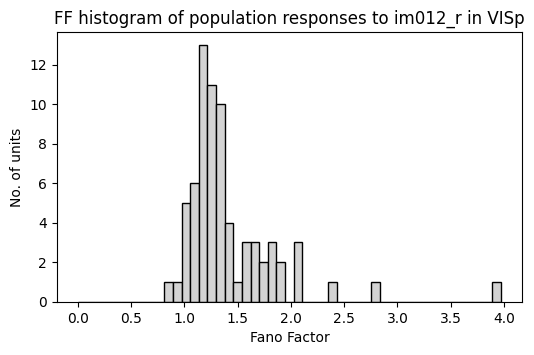

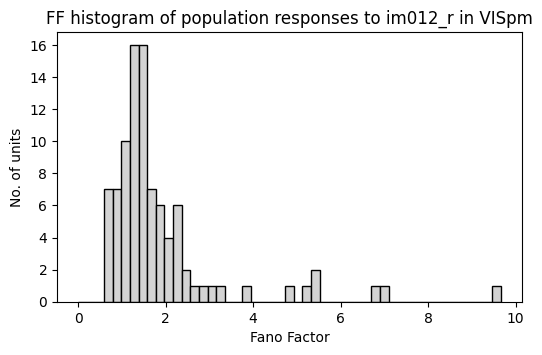

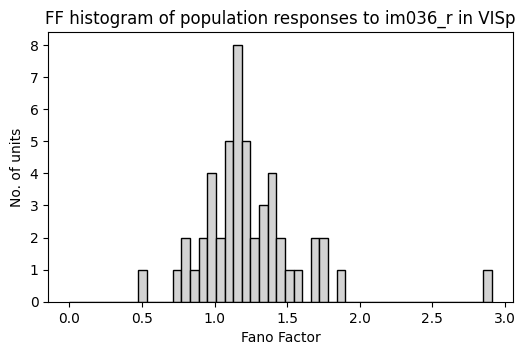

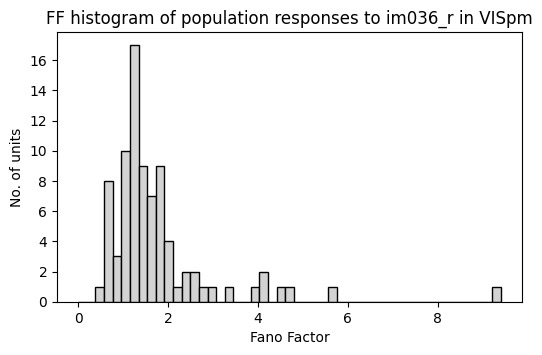

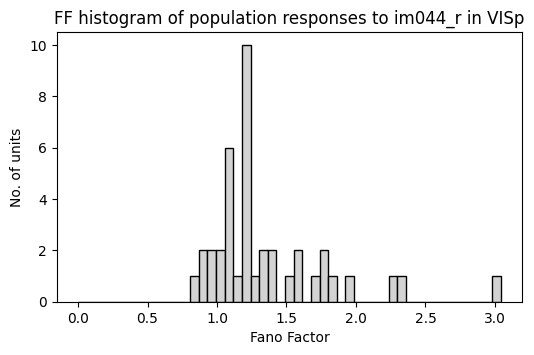

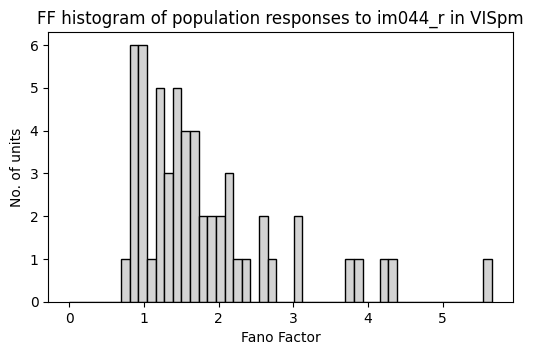

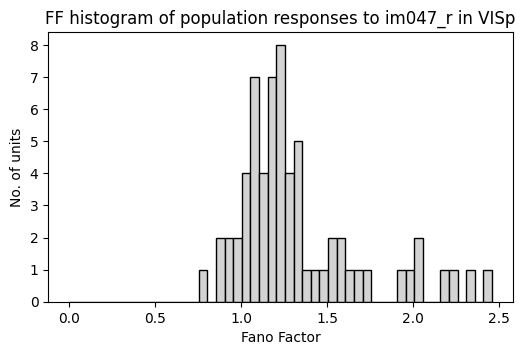

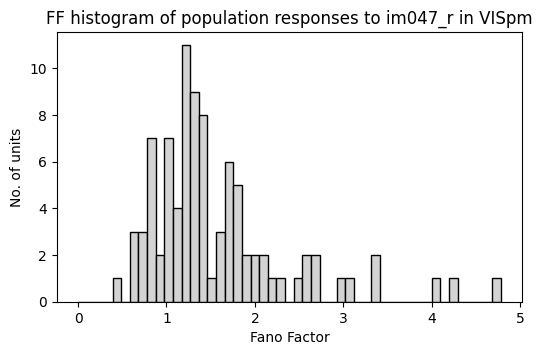

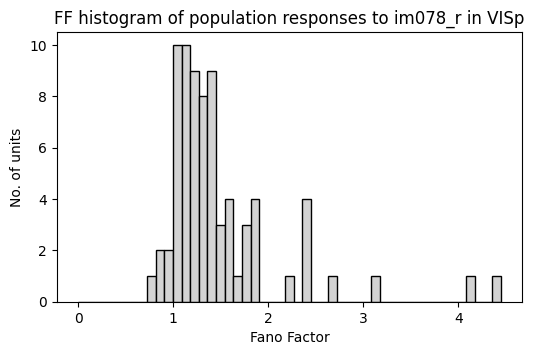

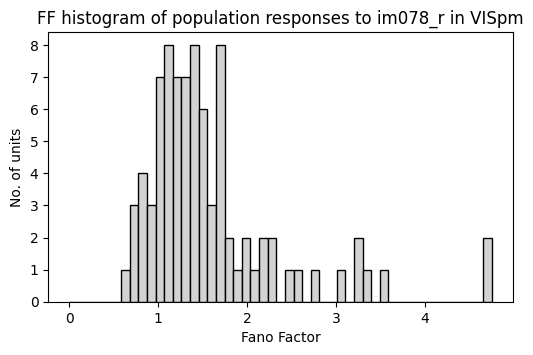

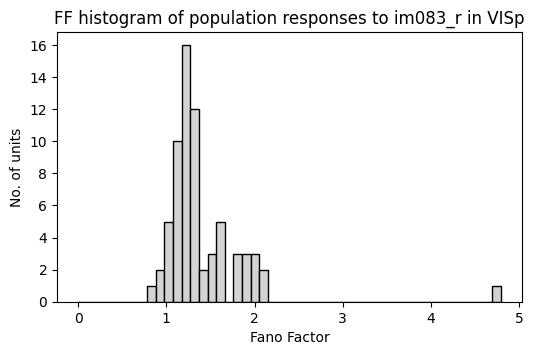

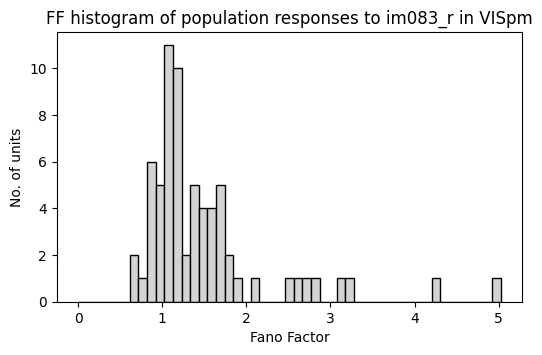

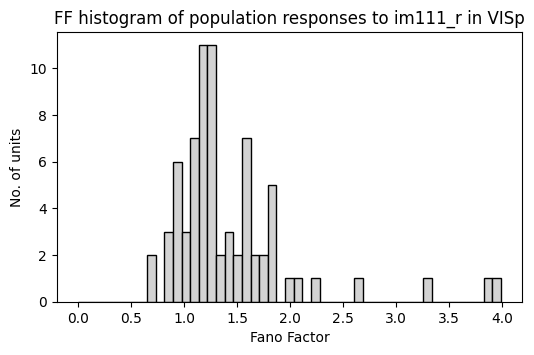

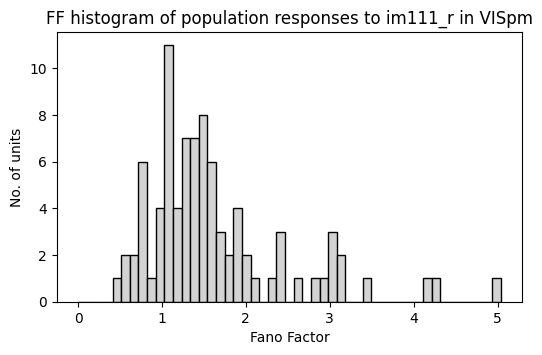

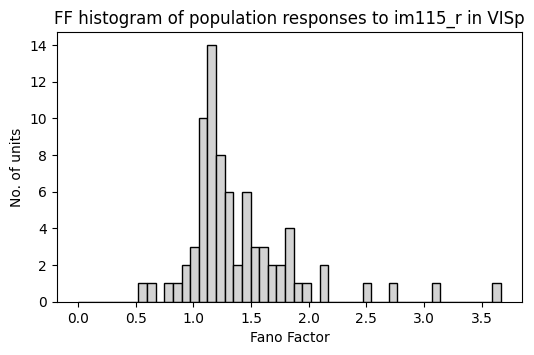

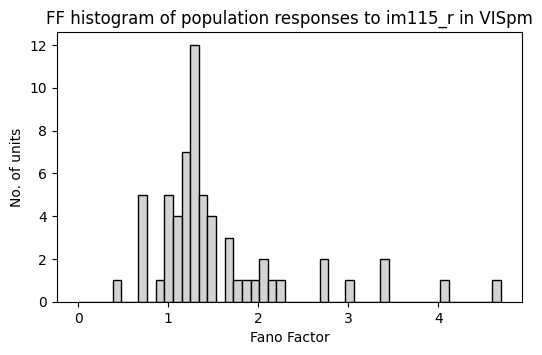

In [27]:
baseline_window = (-0.25, 0)
evoked_window = (0, 0.25)
ei = np.searchsorted(bins, evoked_window)

image_evoked_stats = {}

for image, area_cubes in image_cubes.items():

  area_evoked_stats = {}

  for area, cube in area_cubes.items():

    evoked_count = cube[:,:,ei[0]:ei[1]].sum(axis=2)
    evoked_mean = evoked_count.mean(axis=1)
    evoked_variance = np.var(evoked_count, axis=1, ddof=1)
    area_evoked_stats[area] = {
      "means": evoked_mean,
      "vars": evoked_variance,
    }
  
  image_evoked_stats[image] = area_evoked_stats

del image_evoked_stats['omitted']

image_medians = {}

for image, image_stats in image_evoked_stats.items():

  medians = {}

  for area, area_stats in image_stats.items():

    means = area_stats['means']
    fano = area_stats['vars'] / (means + 1e-9)
    medians[area] = np.median(fano)

    fig, ax = plt.subplots(figsize=(6, 3.5))
    bins_hist = np.linspace(0,max(fano), 50)

    ax.hist(fano, bins_hist, color='lightgrey', edgecolor='black')
    ax.set_ylabel('No. of units')
    ax.set_xlabel('Fano Factor')
    ax.set_title(f'FF histogram of population responses to {image} in {area}')


  image_medians[image] = medians


print(image_medians)

(84, 9)
(176, 9)


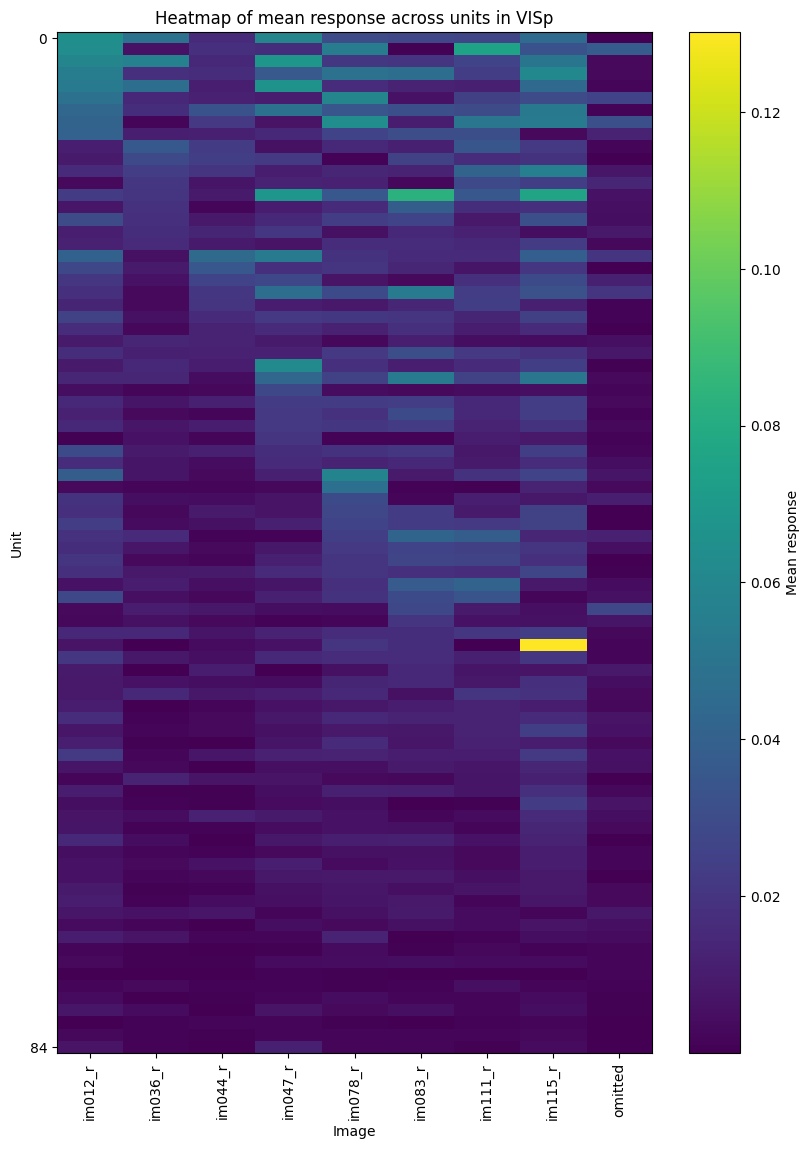

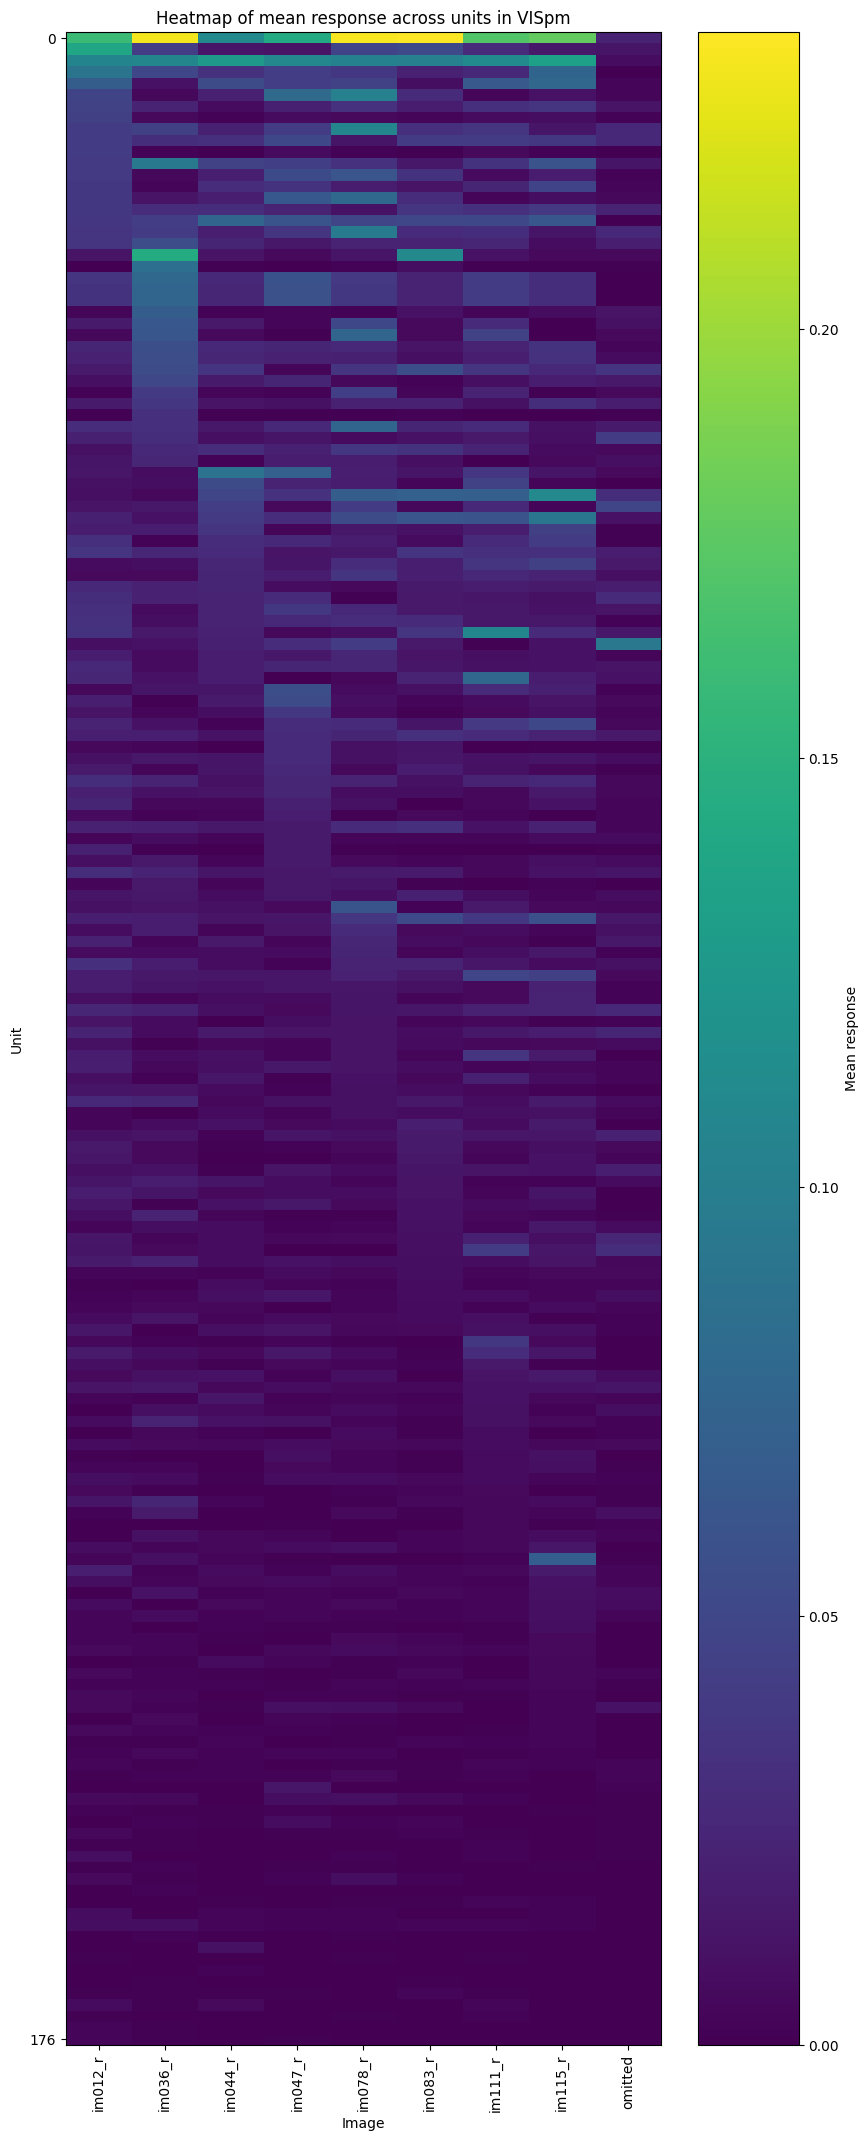

In [ ]:
# Visualising the evoked means as a heatmap across each unit and each image for both V1Sp and V1Spm

for area, ie in area_evoked_means.items():

  images = list(ie.keys())
  arrays = [np.array(ie[img]) for img in images]

  M = np.column_stack(arrays)
  M = abs(M)

  n_units, n_images = M.shape

  print(M.shape)

  quo, rem = divmod(n_units, n_images)

  remaining = np.arange(n_units)
  ots = []
  quota = quo                              

  for i in range(n_images):
    order_i = remaining[np.argsort(M[remaining, i])[::-1]]
    ot = order_i[:quota]           
    ots.append(ot)
    remaining = np.setdiff1d(remaining, ot, assume_unique=True)

  ots = np.concatenate(ots) if ots else np.array([], dtype=int)
  order = np.concatenate((ots, remaining))

  M = M[order]

  fig_h = max(3.5, 0.14 * n_units + 1.5)  
  fig_w = max(4.0, 0.9 * n_images + 1.5) 
  fig, ax = plt.subplots(figsize=(fig_w, fig_h))

  im = ax.imshow(M, cmap='viridis', aspect='auto')
  cbar = fig.colorbar(im, ax=ax)
  cbar.set_label("Mean response")

  ax.set_xlabel("Image")
  ax.set_ylabel("Unit")
  ax.set_title(f"Heatmap of mean response across units in {area}")

  ax.set_xticks(np.arange(n_images))
  ax.set_xticklabels(images, rotation=90)

  ax.set_yticks([0, n_units - 1])
  ax.set_yticklabels([0, n_units])




In [ ]:
# Obtaining stimulus onsets by trial for each image

image_frame_onsets = {}

for image, onsets in onsets_by_image.items():

  image_trials = get_image_trials(trials, image, onsets)
  trial_frame_onsets = arrange_image_onsets_to_trial(image_trials)
  frame_onsets = group_stims_by_frame_index(trial_frame_onsets)

  image_frame_onsets[image] = frame_onsets

/Users/elliotpallister/Documents/University/4TH YEAR/PROJECT CODE/src/pareto/preprocessing.py:65: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  .apply(list)


In [ ]:
# Obtaining evoked responses for each onset matched to frame index for each unit and image in VISp and VISpm, 
# and mean evoked response and variability for each frame index for each image for both areas

area_frame_evoked = {}
area_frame_stats = {}

for area, cubes in area_cubes.items():

  image_frame_evoked = {}

  for image, frame_onsets in image_frame_onsets.items():

    frame_onsets = pd.DataFrame(frame_onsets)

    image_cube = cubes[image]
    frame_evoked = {}

    for row in frame_onsets.itertuples(index=False):

      fi = row.frame_index
      onsets = row.onsets

      frame_indices = np.searchsorted(onsets_by_image[image], onsets)
      per_frame_evoked = image_cube[:,frame_indices, ei[0]:ei[1]]
      frame_evoked[fi] = per_frame_evoked

    image_frame_evoked[image] = frame_evoked

  del image_frame_evoked['omitted']

  area_frame_evoked[area] = image_frame_evoked

  image_frame_stats = {}

  for image, frame_evoked in image_frame_evoked.items():

    frame_stats = {}

    for frame, cube in frame_evoked.items():

      per_onset_evoked = cube.mean(axis=2)
      mean_evoked = cube.mean(axis=1)
      var_evoked = per_onset_evoked.var(axis=1)
      frame_stats[frame] = {
        'means': mean_evoked,
        'vars': var_evoked
      }
    
    image_frame_stats[image] = frame_stats

  area_frame_stats[area] = image_frame_stats
